<a href="https://colab.research.google.com/github/vivekbasappa/helloworld/blob/master/OLMAR_Strategy_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  5 of 5 completed
<ipython-input-34-d50405fcc915>:119: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  returns_history = pd.concat([returns_history, new_return], ignore_index=True)


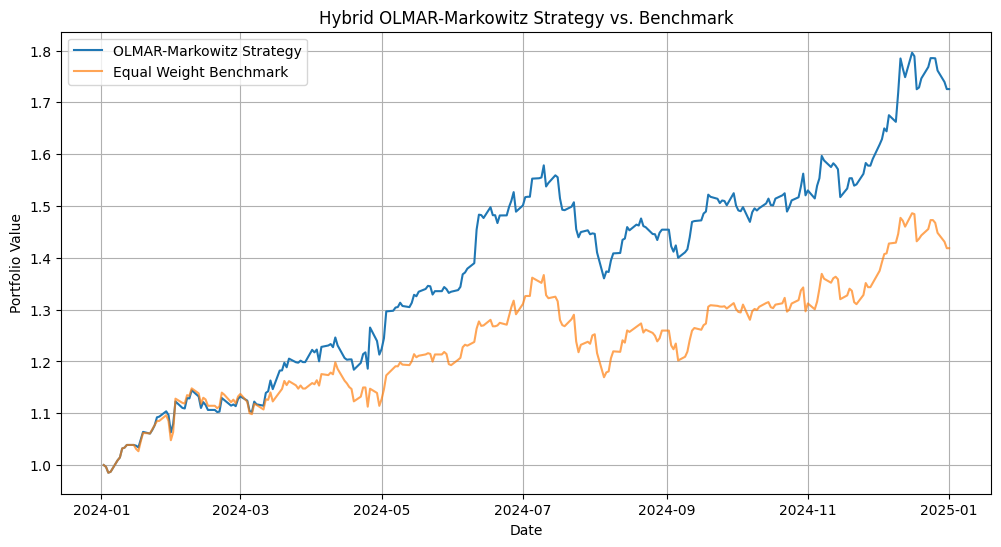

Final Portfolio Value (OLMAR-Markowitz): 1.73
Final Benchmark Value: 1.42
Approximate CAGR (OLMAR-Markowitz): 69.00%
Approximate CAGR (Benchmark): 39.97%


<ipython-input-34-d50405fcc915>:211: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  olmar_final = portfolio['Portfolio Value'][-1]
<ipython-input-34-d50405fcc915>:212: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  benchmark_final = benchmark_df['Benchmark'][-1]


In [34]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import cvxpy as cp

class OLMAR_Markowitz:
    def __init__(self, stocks, lookback=10, epsilon=1e-8, risk_aversion=1.0):
        """
        Initialize the OLMAR with Markowitz Optimization strategy.

        Parameters:
        - stocks: List of stock tickers.
        - lookback: Number of past days to consider for moving average.
        - epsilon: Small constant to prevent division by zero.
        - risk_aversion: Parameter to control the trade-off between return and risk in Markowitz optimization.
        """
        self.stocks = stocks
        self.lookback = lookback
        self.epsilon = epsilon
        self.risk_aversion = risk_aversion
        self.num_stocks = len(stocks)
        self.weights = np.array([1.0 / self.num_stocks] * self.num_stocks)  # Start with equal weights
        self.weight_history = [self.weights.copy()]
        self.portfolio_values = [1.0]  # Start with portfolio value of 1

    def fetch_data(self, start_date, end_date):
        """
        Fetch historical adjusted close prices for the selected stocks.

        Parameters:
        - start_date: Start date for fetching data (YYYY-MM-DD).
        - end_date: End date for fetching data (YYYY-MM-DD).

        Returns:
        - DataFrame of adjusted close prices with missing data handled.
        """
        data = yf.download(self.stocks, start=start_date, end=end_date)['Adj Close']

        # Ensure the DataFrame has a DateTime index
        if not isinstance(data.index, pd.DatetimeIndex):
            data.index = pd.to_datetime(data.index)

        # Reindex to include all possible trading days within the range
        all_days = pd.date_range(start=start_date, end=end_date, freq='B')  # 'B' for business days
        data = data.reindex(all_days)

        # Handle missing data
        data = data.ffill().bfill()  # Forward fill, then backward fill

        # Alternatively, you can use interpolation if preferred
        # data = data.interpolate(method='linear').ffill().bfill()

        return data

    def markowitz_optimize(self, returns_history):
        """
        Perform Markowitz Portfolio Optimization to determine optimal weights.

        Parameters:
        - returns_history: DataFrame of historical returns.

        Returns:
        - Optimal weights as a NumPy array.
        """
        # Calculate expected returns and covariance matrix
        expected_returns = returns_history.mean().values
        cov_matrix = returns_history.cov().values

        # Define optimization variables
        w = cp.Variable(self.num_stocks)

        # Define the objective: Maximize expected return - risk_aversion * portfolio variance
        objective = cp.Maximize(expected_returns @ w - self.risk_aversion * cp.quad_form(w, cov_matrix))

        # Constraints: Weights sum to 1 and are non-negative
        constraints = [cp.sum(w) == 1, w >= 0]

        # Define and solve the problem
        prob = cp.Problem(objective, constraints)
        prob.solve()

        if w.value is not None:
            optimal_weights = np.array(w.value).flatten()
        else:
            # If optimization fails, revert to equal weights
            optimal_weights = np.array([1.0 / self.num_stocks] * self.num_stocks)

        return optimal_weights

    def run(self, data):
        """
        Run the hybrid OLMAR-Markowitz strategy on the provided data.

        Parameters:
        - data: DataFrame of adjusted close prices.

        Returns:
        - DataFrame with portfolio value over time.
        """
        prices = data.pct_change().dropna().copy()
        num_days, num_stocks = prices.shape

        # To store historical returns for Markowitz
        returns_history = pd.DataFrame(columns=self.stocks)

        for t in range(num_days):
            current_date = data.index[t + 1]  # +1 because pct_change drops the first row
            if t < self.lookback:
                # Not enough data to compute moving average; keep initial weights
                portfolio_return = np.dot(self.weights, prices.iloc[t].values)
                new_portfolio_value = self.portfolio_values[-1] * (1 + portfolio_return)
                self.portfolio_values.append(new_portfolio_value)
                self.weight_history.append(self.weights.copy())
                # Update returns history

                # **Updated Code: Replace append with pd.concat**
                new_return = prices.iloc[t].to_frame().T  # Convert Series to DataFrame
                returns_history = pd.concat([returns_history, new_return], ignore_index=True)

                continue

            # Update returns history

            # **Updated Code: Replace append with pd.concat**
            new_return = prices.iloc[t].to_frame().T  # Convert Series to DataFrame
            returns_history = pd.concat([returns_history, new_return], ignore_index=True)

            if len(returns_history) > self.lookback:
                returns_history = returns_history.iloc[1:].reset_index(drop=True)

            # Compute moving average of past 'lookback' days
            past_prices = data.iloc[t - self.lookback:t].values
            mean_prices = np.mean(past_prices, axis=0)
            current_prices = data.iloc[t].values
            # Calculate relative prices (current / mean)
            relative_prices = current_prices / (mean_prices + self.epsilon)

            # Normalize relative prices to form a reference portfolio
            reference_portfolio = relative_prices / np.sum(relative_prices)

            # OLMAR weight adjustment: Move towards the reference portfolio
            olmar_weights = reference_portfolio
            olmar_weights = np.maximum(olmar_weights, 0)
            olmar_weights /= np.sum(olmar_weights)

            # Markowitz optimization based on historical returns
            markowitz_weights = self.markowitz_optimize(returns_history)

            # Combine OLMAR and Markowitz weights
            # Here, we take a weighted average; you can adjust the combination method as desired
            combined_weights = 0.5 * olmar_weights + 0.5 * markowitz_weights
            combined_weights = np.maximum(combined_weights, 0)
            combined_weights /= np.sum(combined_weights)

            # Update portfolio weights
            self.weights = combined_weights

            # Calculate portfolio return
            portfolio_return = np.dot(self.weights, prices.iloc[t].values)
            new_portfolio_value = self.portfolio_values[-1] * (1 + portfolio_return)

            # Update history
            self.portfolio_values.append(new_portfolio_value)
            self.weight_history.append(self.weights.copy())

        portfolio_df = pd.DataFrame({
            'Portfolio Value': self.portfolio_values[1:]
        }, index=data.index[1:])

        return portfolio_df

def main():
    # Define your selected stocks
    selected_stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']  # Example: Tech giants

    # Initialize Hybrid OLMAR-Markowitz strategy
    olmar_markowitz = OLMAR_Markowitz(stocks=selected_stocks, lookback=10, risk_aversion=1.0)

    # Fetch historical data
    start_date = '2024-01-01'
    end_date = '2025-01-01'  # Adjust as needed
    data = olmar_markowitz.fetch_data(start_date, end_date)

    # Run the hybrid strategy
    portfolio = olmar_markowitz.run(data)

    # Fetch benchmark (e.g., equally weighted portfolio)
    equal_weights = np.array([1.0 / len(selected_stocks)] * len(selected_stocks))
    benchmark_returns = data.pct_change().dropna().dot(equal_weights)
    benchmark_values = (1 + benchmark_returns).cumprod()
    benchmark_df = pd.DataFrame({
        'Benchmark': benchmark_values
    }, index=data.index[1:])

    # Combine portfolio and benchmark
    comparison = pd.concat([portfolio, benchmark_df], axis=1)

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(comparison.index, comparison['Portfolio Value'], label='OLMAR-Markowitz Strategy')
    plt.plot(comparison.index, comparison['Benchmark'], label='Equal Weight Benchmark', alpha=0.7)
    plt.title('Hybrid OLMAR-Markowitz Strategy vs. Benchmark')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Performance Metrics
    olmar_final = portfolio['Portfolio Value'][-1]
    benchmark_final = benchmark_df['Benchmark'][-1]
    olmar_cagr = (olmar_final) ** (252 / len(portfolio)) - 1  # Approximate CAGR assuming 252 trading days
    benchmark_cagr = (benchmark_final) ** (252 / len(benchmark_df)) - 1
    print(f"Final Portfolio Value (OLMAR-Markowitz): {olmar_final:.2f}")
    print(f"Final Benchmark Value: {benchmark_final:.2f}")
    print(f"Approximate CAGR (OLMAR-Markowitz): {olmar_cagr * 100:.2f}%")
    print(f"Approximate CAGR (Benchmark): {benchmark_cagr * 100:.2f}%")

if __name__ == "__main__":
    main()
